<a href="https://colab.research.google.com/github/joms-hub/SEE/blob/main/output/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Sessa Empirical Estimator (SEE)

*Assignment by Jomar Cunado and January Venice Toledo*

### Instructions

Assignment 2 For Clustering: Sessa Empirical Estimator

1. Read the Journals about the Sessa Empirical Estimator.
2. Convert the R codes into Python Codes (use jupyter notebook).
Using Simulated data (https://www.frontiersin.org/journals/pharmacology/articles/10.3389/fphar.2019.00383/full) or a real world datasets of your choice (You can obtain it in Kaggle or in https://archive.ics.uci.edu/), perform the Sessa Empircal Estimator and generate some insights.
4. The Sessa Empirical Estimator uses K-Means clustering (again recall the disadvantages of K-Means), try to substitute a different clustering algorithm, generate a new insight using the new clustering algorithm.
5. Compare your results between Sessa Empirical Estimator using K-Means, and Sessa Empirical Estimator using the clustering algorithm of your choice.
6. Deadline is this Tuesday, Feb 25, 2025 at 11:59 pm
7. Do this with your thesis partner.
8. You can use any A.I. assistant.

---
## Background and Purpose  
The **Sessa Empirical Estimator (SEE)** is a data-driven method designed to estimate the duration of prescription drug use, particularly when information on dosage and daily consumption is incomplete or unavailable. It offers a more **systematic and objective** approach compared to traditional methods, which often rely on assumptions.

In pharmacoepidemiology—the study of medication use and its effects on populations—it is crucial to determine how long patients remain on a given treatment. Understanding this duration helps researchers assess **treatment adherence, effectiveness, and potential risks**. However, prescription records often lack details on intended treatment duration, making it difficult to track continuous drug exposure accurately.

To address this, SEE was developed as a **more precise alternative** to traditional approaches like **Researcher-Defined Duration (RDD)**, which assumes a fixed daily dosage. Instead, SEE uses **real-world prescription patterns** to estimate treatment duration, minimizing bias and improving accuracy.

## How It Works  
SEE operates in several key steps:

1. **Analyzing prescription refill patterns**  
   - The method examines how often patients refill their prescriptions. To avoid distortions caused by irregular refill behaviors, SEE filters out unusually long gaps between refills.

2. **Selecting representative prescription pairs**  
   - Instead of analyzing every refill, SEE selects one random pair per patient to **avoid overrepresentation** of frequent refills.

3. **Grouping similar refill behaviors**  
   - Using a **k-means clustering algorithm**, SEE identifies different prescription duration patterns across the patient population. This ensures that prescription lengths are estimated based on **realistic usage trends** rather than arbitrary assumptions.

4. **Determining treatment exposure periods**  
   - For each cluster, SEE calculates a **median prescription duration** and applies it to estimate how long a patient was likely exposed to the medication.

## Effectiveness and Accuracy  
SEE has been tested in both **simulated data** and **real-world prescription records**:

- In controlled simulations, it achieved **96% accuracy** in estimating prescription durations.
- In studies using Danish healthcare data, SEE demonstrated **high sensitivity (78–95%)**, outperforming traditional methods.
- When compared to RDD, SEE showed **lower error rates and greater adaptability** across different drug types.

## Applications in Research  
SEE has been applied in several studies to improve our understanding of **medication adherence and co-exposure** to multiple drugs. Examples include:

- **Antihypertensive medications**: SEE was used to track how long patients remained on combination therapies.
- **Drug safety studies**: It helped assess whether prolonged exposure to the anti-seizure drug **lamotrigine** was linked to an increased risk of cardiovascular events.
- **Pharmacoepidemiological research**: SEE has been integrated into frameworks to enhance the accuracy of drug exposure assessments.

## Significance
By relying on **data-driven insights rather than fixed assumptions**, SEE provides a **more reliable and flexible** way to estimate prescription durations. This improves the quality of research in drug safety, treatment effectiveness, and public health policy, ultimately helping to ensure that medications are used safely and effectively in real-world settings.


# A. INITIALIZATION

## I. Import Libraries



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# DBScan Libraries
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

# Check if file exists before attempting to load dataset
from pathlib import Path

## II. Setup Sample Data


In [3]:
file_path = '../csv/med_events.csv'

if Path(file_path).is_file():
    medical_events = pd.read_csv(file_path)
    print("CSV file loaded successfully!")

    # Convert date column to datetime (assuming 'DATE' is the column name in your CSV)
    medical_events["DATE"] = pd.to_datetime(medical_events["DATE"])

    # Change column names
    medical_events.columns = ["pnr", "eksd", "perday", "ATC", "dur_original"]

    # Display the first few rows
    print(medical_events.head())
else:
    print(f"Error: File not found at {file_path}. Ensure the file exists.")

CSV file loaded successfully!
   pnr       eksd  perday   ATC  dur_original
0    1 2033-04-26       4  medA            50
1    1 2033-07-04       4  medB            30
2    1 2033-08-03       4  medB            30
3    1 2033-08-17       4  medB            30
4    1 2033-10-13       4  medB            30


# B. Callable Functions

## I. SEE using **K-means**

In [15]:
def see_k(arg1):
    # Filter dataset for the specified medication
    filtered_data = medical_events[medical_events["ATC"] == arg1].copy()
    
    # Sort and create a prior prescription date column
    filtered_data = filtered_data.sort_values(["pnr", "eksd"]).copy()
    filtered_data["prev_eksd"] = filtered_data.groupby("pnr")["eksd"].shift(1)
    
    # Remove rows where prev_eksd is NaN
    filtered_data = filtered_data.dropna().copy()
    
    # Compute event interval (time difference)
    filtered_data["event_interval"] = (filtered_data["eksd"] - filtered_data["prev_eksd"]).dt.days

    # Remove non-positive event intervals
    filtered_data = filtered_data[filtered_data["event_interval"] > 0].copy()

    if filtered_data.empty:
        print("No valid data after filtering.")
        return pd.DataFrame()

    # Sort full dataset
    sorted_intervals_full = np.sort(filtered_data["event_interval"])
    
    # Find 80% cutoff
    cutoff_value = sorted_intervals_full[int(0.8 * len(sorted_intervals_full))]
    
    # Create 80% dataset (excluding top 20% of values)
    filtered_80 = filtered_data[filtered_data["event_interval"] <= cutoff_value].copy()

    # Compute ECDF values
    def compute_ecdf(data):
        sorted_data = np.sort(data)
        ecdf_y = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
        return sorted_data, ecdf_y

    x_full, y_full = compute_ecdf(sorted_intervals_full)
    x_80, y_80 = compute_ecdf(filtered_80["event_interval"])

    # Create figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Plot ECDF for 100% data
    axes[0].plot(x_80, y_80, marker="o", linestyle="-", markersize=3, color="darkgreen")
    axes[0].set_title("ECDF (80% Data)")
    axes[0].set_xlabel("Event Interval (days)")
    axes[0].set_ylabel("Cumulative Probability")
    axes[0].grid(True)

    # Plot ECDF for 80% data
    axes[1].plot(x_full, y_full, marker="o", linestyle="-", markersize=3, color="purple")
    axes[1].set_title("ECDF (100% Data)")
    axes[1].set_xlabel("Event Interval (days)")
    axes[1].set_ylabel("Cumulative Probability")
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

    return filtered_data

## II. SEE using **DBScan**

In [5]:
def see_dbscan(arg1):
    # Filter dataset for the specified medication
    filtered_data = medical_events[medical_events["ATC"] == arg1].copy()

    # Sort and create a prior prescription date column
    filtered_data = filtered_data.sort_values(["pnr", "eksd"]).copy()
    filtered_data["prev_eksd"] = filtered_data.groupby("pnr")["eksd"].shift(1)

    # Remove rows where prev_eksd is NaN
    filtered_data = filtered_data.dropna().copy()

    # Select one random record per patient
    filtered_data = filtered_data.groupby("pnr").sample(n=1, random_state=5678).copy()

    # Compute event interval (time difference)
    filtered_data["event_interval"] = (filtered_data["eksd"] - filtered_data["prev_eksd"]).dt.days

    # Remove non-positive event intervals
    filtered_data = filtered_data[filtered_data["event_interval"] > 0].copy()

    # Compute ECDF
    if filtered_data.empty:
        return pd.DataFrame()  # Return empty DataFrame if no valid data

    sorted_intervals = np.sort(filtered_data["event_interval"])
    ecdf_y = np.arange(1, len(sorted_intervals) + 1) / len(sorted_intervals)

    # Keep only the lower 80% of ECDF
    max_value = sorted_intervals[int(0.8 * len(sorted_intervals))]
    filtered_subset = filtered_data[filtered_data["event_interval"] <= max_value].copy()

    # Ensure filtered_subset is not empty
    if filtered_subset.empty:
        return pd.DataFrame()  # Return empty DataFrame if no valid data

    # Remove non-positive values before applying log
    filtered_subset = filtered_subset[filtered_subset["event_interval"] > 0]

    # Density plot of log-transformed event intervals
    if len(filtered_subset) > 1:  # Ensure there's enough data for KDE
        kde = gaussian_kde(np.log(filtered_subset["event_interval"]))
        x_values = np.linspace(min(np.log(filtered_subset["event_interval"])),
                                max(np.log(filtered_subset["event_interval"])), 100)
        y_values = kde(x_values)
    else:
        return pd.DataFrame()  # Return empty DataFrame if insufficient data for KDE

    # Normalize the data for clustering
    scaler = StandardScaler()
    scaled_intervals = scaler.fit_transform(filtered_subset[["event_interval"]])

    # Determine the optimal epsilon (eps) using k-distance method
    if len(scaled_intervals) < 5:
        return pd.DataFrame()  # Return empty DataFrame if not enough data for DBSCAN

    neighbor = NearestNeighbors(n_neighbors=5)
    neighbor.fit(scaled_intervals)
    distances, _ = neighbor.kneighbors(scaled_intervals)
    k_distances = np.sort(distances[:, -1])  # Take the 5th neighbor distance

    # Choose eps as the "knee" point (approximation: 90th percentile of distances)
    eps_value = np.percentile(k_distances, 90)

    # Apply DBSCAN clustering
    dbscan = DBSCAN(eps=eps_value, min_samples=5)
    filtered_subset.loc[:, "cluster"] = dbscan.fit_predict(scaled_intervals)

    # Handle noise points (DBSCAN assigns -1 to noise)
    filtered_subset.loc[filtered_subset["cluster"] == -1, "cluster"] = np.nan

    # Cluster summary
    cluster_summary = filtered_subset.groupby("cluster")["event_interval"].agg(["min", "max", "median"]).reset_index()

    # Merge clusters back to main dataset
    results = filtered_subset.merge(cluster_summary, on="cluster", how="left")
    results = results[(results["event_interval"] >= results["min"]) & (results["event_interval"] <= results["max"])]

    # Assign cluster to all data
    final_result = medical_events[medical_events["ATC"] == arg1].copy()
    final_result = final_result.merge(results[["pnr", "median", "cluster"]], on="pnr", how="left")

    # Fill missing cluster values safely
    final_result["cluster"] = final_result["cluster"].fillna(0)
    final_result["median"] = final_result["median"].fillna(results["median"].median())

    return final_result

## III. SEE Assumption

In [11]:
def see_assump(data):
    data = data.copy()
    
    # Sort and create previous prescription date column
    data.sort_values(["pnr", "eksd"], inplace=True)
    data["prev_eksd"] = data.groupby("pnr")["eksd"].shift(1)
    
    # Remove rows where prev_eksd is NaN
    data = data.dropna()
    
    # Compute duration between prescriptions
    data["duration"] = (data["eksd"] - data["prev_eksd"]).dt.days
    
    # Assign sequence number per patient
    data["p_number"] = data.groupby("pnr").cumcount() + 1
    
    # Filter only patients with at least 2 prescriptions
    data = data[data["p_number"] >= 2]
    
    # Select only the needed columns
    Drug_see2 = data[['pnr', 'eksd', 'prev_eksd', 'p_number', 'duration']]

    # Boxplot with uniform color
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='p_number', y='duration', data=Drug_see2, color="skyblue")
    plt.title("Duration Between Prescriptions", color="darkblue")
    plt.xlabel("Prescription Number", color="darkblue")
    plt.ylabel("Duration (days)", color="darkblue")
    
    # Compute median of medians per patient
    medians_of_medians = Drug_see2.groupby("pnr")["duration"].median()
    
    # Overlay median line for overall median duration
    plt.axhline(medians_of_medians.median(), color="red", linestyle="dashed", label='Overall Median')
    plt.legend()
    plt.show()

    return Drug_see2  # Optionally return the processed DataFrame

# C. Execution

## I. Using **K-means**


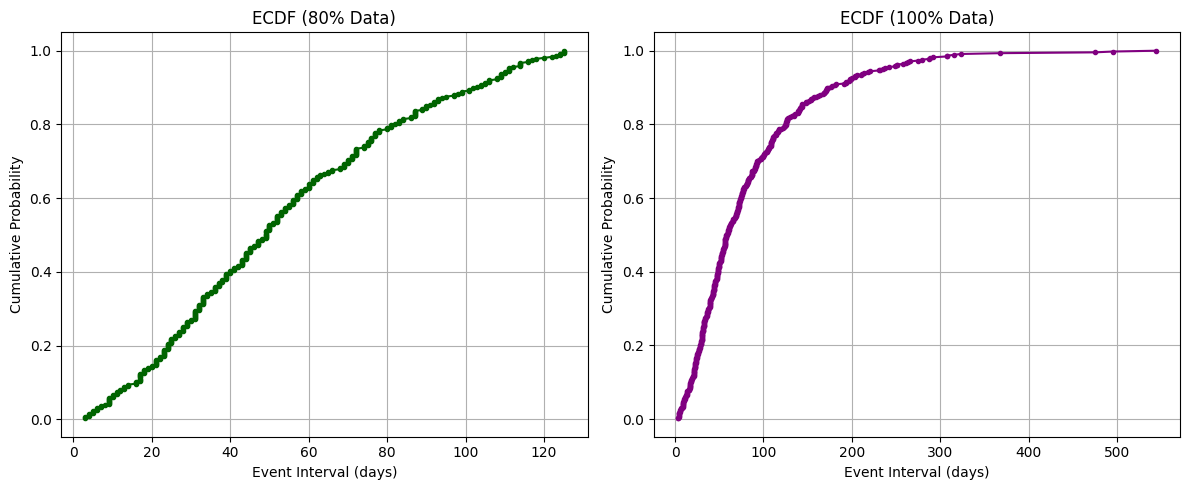

,pnr,eksd,perday,ATC,dur_original,prev_eksd,event_interval
25,2,2036-03-10,4,medA,50,2036-01-20,50
26,2,2036-08-01,4,medA,50,2036-03-10,144
61,4,2032-11-27,4,medA,50,2032-05-01,210
62,4,2033-08-20,4,medA,50,2032-11-27,266
63,4,2033-08-30,4,medA,50,2033-08-20,10
...,...,...,...,...,...,...,...
1056,98,2034-02-25,4,medA,50,2034-01-02,54
1057,98,2034-12-10,4,medA,50,2034-02-25,288
1060,99,2032-06-16,4,medA,50,2031-11-08,221
1062,99,2032-09-18,4,medA,50,2032-06-16,94


In [25]:
med_a_k = see_k("medA")
med_a_k

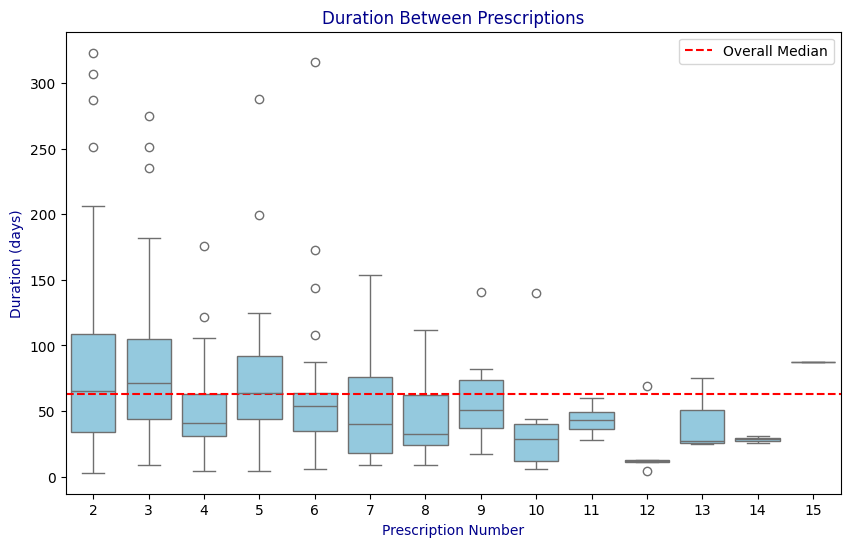

,pnr,eksd,prev_eksd,p_number,duration
63,4,2033-08-30,2033-08-20,2,10
64,4,2033-12-17,2033-08-30,3,109
69,5,2032-03-04,2032-01-25,2,39
70,5,2032-09-02,2032-03-04,3,182
71,5,2032-12-17,2032-09-02,4,106
...,...,...,...,...,...
1028,96,2043-05-07,2043-04-17,10,20
1054,98,2033-09-14,2033-06-16,2,90
1055,98,2034-01-02,2033-09-14,3,110
1056,98,2034-02-25,2034-01-02,4,54


In [26]:
see_assump(med_a_k)

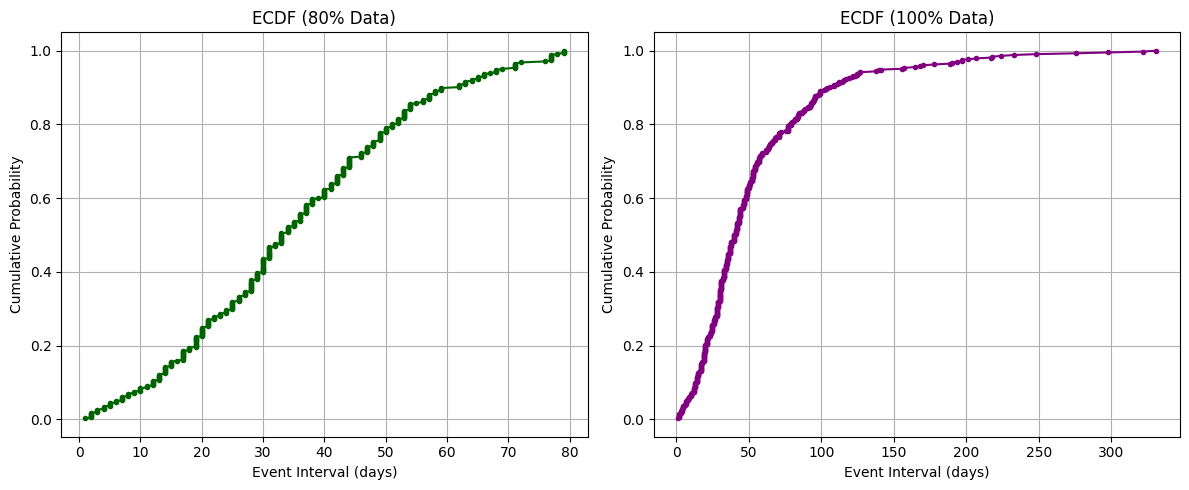

,pnr,eksd,perday,ATC,dur_original,prev_eksd,event_interval
2,1,2033-08-03,4,medB,30,2033-07-04,30
3,1,2033-08-17,4,medB,30,2033-08-03,14
4,1,2033-10-13,4,medB,30,2033-08-17,57
5,1,2033-10-16,4,medB,30,2033-10-13,3
6,1,2033-11-23,4,medB,30,2033-10-16,38
...,...,...,...,...,...,...,...
1075,100,2034-03-05,6,medB,30,2034-01-22,42
1076,100,2034-04-07,6,medB,30,2034-03-05,33
1077,100,2034-04-26,6,medB,30,2034-04-07,19
1078,100,2034-05-26,6,medB,30,2034-04-26,30


In [27]:
med_b_k = see_k("medB")
med_b_k

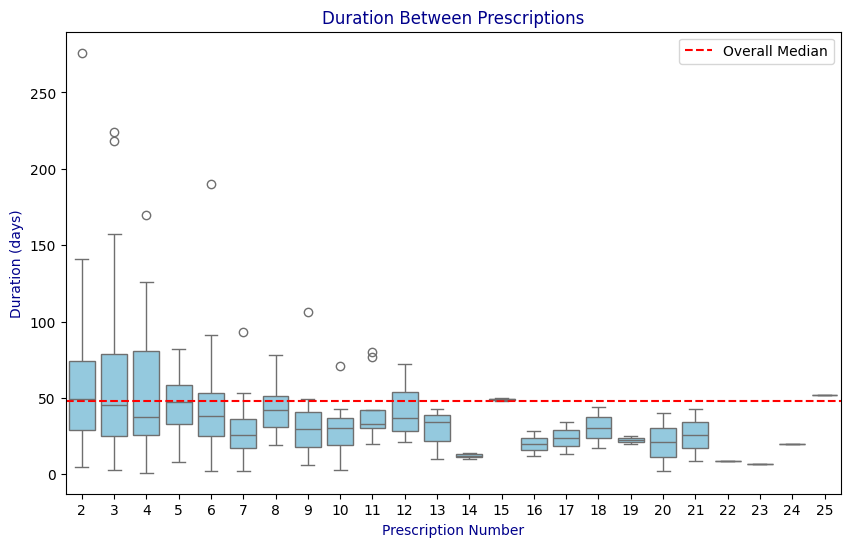

,pnr,eksd,prev_eksd,p_number,duration
4,1,2033-10-13,2033-08-17,2,57
5,1,2033-10-16,2033-10-13,3,3
6,1,2033-11-23,2033-10-16,4,38
7,1,2034-01-19,2033-11-23,5,57
8,1,2034-02-08,2034-01-19,6,20
...,...,...,...,...,...
1075,100,2034-03-05,2034-01-22,8,42
1076,100,2034-04-07,2034-03-05,9,33
1077,100,2034-04-26,2034-04-07,10,19
1078,100,2034-05-26,2034-04-26,11,30


In [28]:
see_assump(med_b_k)

## II. Using DBScan

In [21]:
med_a_db = see_dbscan("medA")
med_a_db

,pnr,eksd,perday,ATC,dur_original,median,cluster
0,1,2033-04-26,4,medA,50,60.0,0.0
1,2,2036-01-20,4,medA,50,60.0,0.0
2,2,2036-03-10,4,medA,50,60.0,0.0
3,2,2036-08-01,4,medA,50,60.0,0.0
4,3,2042-04-13,4,medA,50,60.0,0.0
...,...,...,...,...,...,...,...
544,99,2031-11-08,4,medA,50,60.0,0.0
545,99,2032-06-16,4,medA,50,60.0,0.0
546,99,2032-09-18,4,medA,50,60.0,0.0
547,100,2032-08-05,2,medA,150,60.0,0.0


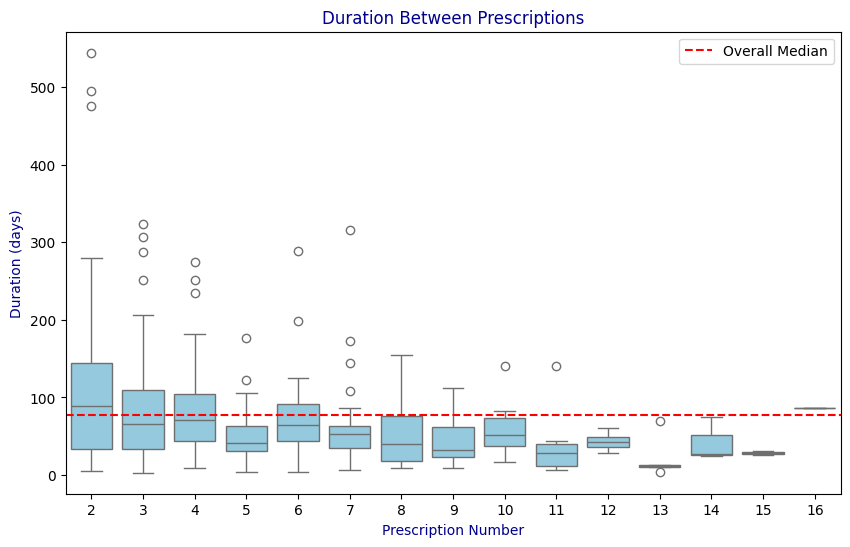

,pnr,eksd,prev_eksd,p_number,duration
3,2,2036-08-01,2036-03-10,2,144
7,4,2033-08-20,2032-11-27,2,266
8,4,2033-08-30,2033-08-20,3,10
9,4,2033-12-17,2033-08-30,4,109
12,5,2032-01-25,2031-12-27,2,29
...,...,...,...,...,...
540,98,2033-09-14,2033-06-16,3,90
541,98,2034-01-02,2033-09-14,4,110
542,98,2034-02-25,2034-01-02,5,54
543,98,2034-12-10,2034-02-25,6,288


In [22]:
see_assump(med_a_db)

In [23]:
med_b_db = see_dbscan("medB")
med_b_db

,pnr,eksd,perday,ATC,dur_original,median,cluster
0,1,2033-07-04,4,medB,30,40.0,0.0
1,1,2033-08-03,4,medB,30,40.0,0.0
2,1,2033-08-17,4,medB,30,40.0,0.0
3,1,2033-10-13,4,medB,30,40.0,0.0
4,1,2033-10-16,4,medB,30,40.0,0.0
...,...,...,...,...,...,...,...
526,100,2034-03-05,6,medB,30,40.0,0.0
527,100,2034-04-07,6,medB,30,40.0,0.0
528,100,2034-04-26,6,medB,30,40.0,0.0
529,100,2034-05-26,6,medB,30,40.0,0.0


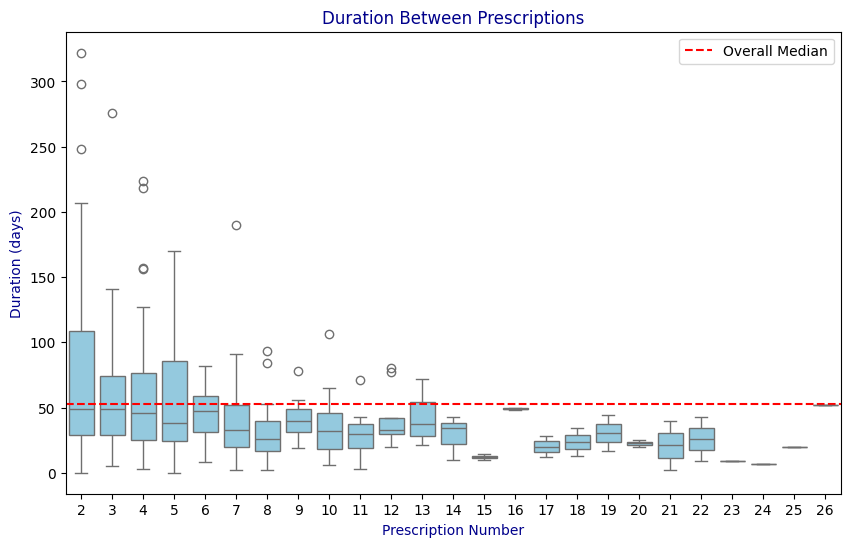

,pnr,eksd,prev_eksd,p_number,duration
2,1,2033-08-17,2033-08-03,2,14
3,1,2033-10-13,2033-08-17,3,57
4,1,2033-10-16,2033-10-13,4,3
5,1,2033-11-23,2033-10-16,5,38
6,1,2034-01-19,2033-11-23,6,57
...,...,...,...,...,...
526,100,2034-03-05,2034-01-22,9,42
527,100,2034-04-07,2034-03-05,10,33
528,100,2034-04-26,2034-04-07,11,19
529,100,2034-05-26,2034-04-26,12,30


In [24]:
see_assump(med_b_db)

## **Comparison: SEE + KMeans vs. SEE + DBSCAN**

### **A. Variability in Early Prescriptions**
#### **SEE + KMeans:**
- Initial prescription phases (low p_number) exhibit **a broad range of refill intervals**.
- Outliers extend **beyond 400–500 days** for medA and **approximately 300 days** for medB.
- Since KMeans assigns all points to clusters, it may **merge atypical refill patterns with regular ones**.

#### **SEE + DBSCAN:**
- Displays similar early variability, but **DBSCAN identifies extreme outliers as noise**.
- More distinctly separates **patients with consistent refill behaviors from those with irregularities**.
- Provides a **more refined representation of standard refill trends** compared to KMeans.

### **B. Stabilization in Later Prescriptions**
#### **SEE + KMeans:**
- **medA:** Achieves stability around p_number **10**, with refill durations narrowing to **50–70 days**.
- **medB:** Becomes more consistent around p_number **15–20**, with durations settling between **20–60 days**.
- Depicts a **progressive shift toward uniform refill habits**.

#### **SEE + DBSCAN:**
- **medA:** Stabilization also occurs near p_number **10**, but the identified clusters appear **more distinct**.
- **medB:** Convergence starts at **15–20**, similar to KMeans, yet with **sharper separation of clusters**.
- Eliminates noise, leading to **a clearer depiction of dominant refill patterns**.

### **C. Overall Performance Comparison**
- KMeans ensures all data points are grouped, making it **less effective in isolating anomalies**.
- DBSCAN, by filtering noise, **emphasizes the core structure of refill behaviors**.
- For applications requiring **a detailed understanding of stable versus inconsistent refill trends**, DBSCAN proves **more effective**.

